In [1]:
'''importing libraries'''
import os
import numpy as np
from pathlib import Path
import glob
import pandas
import plotly.express as px
# Import seaborn
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from plotly.subplots import make_subplots
# conus
from scipy import stats  # for sen's slope
import pymannkendall as mk

# define the study period 1988-2022
years = np.arange(1988, 2023)
agent_codes = [1, 2, 3, 4, 5, 6, 7]


In [2]:
'''load landscape-level data'''

## disturbance frequency to show here
# create an avariable to store the informaiton of the disturbance
des       = '/gpfs/sharedfs1/zhulab/Shi/ProjectCONUSDisturbanceAgent/Analysis/V08PostRelease/hexagon_grid_50km_dist_regime_shift_patch_1988_2022'
data_list = sorted(glob.glob(os.path.join(des, 'grid*.csv')))

distdata_grid = []
for data_file in data_list:
    distdata_grid.append(pandas.read_csv(data_file))
distdata_grid = pandas.concat(distdata_grid) 
# replace agent name to display version
distdata_grid.agent[distdata_grid.agent == 'all'] = 'General'
distdata_grid.agent[distdata_grid.agent == 'forest_management'] = 'Logging'
distdata_grid.agent[distdata_grid.agent == 'construction'] = 'Construction'
distdata_grid.agent[distdata_grid.agent == 'agriculture_activity'] = 'Agricultural change'
distdata_grid.agent[distdata_grid.agent == 'stress'] = 'Stress'
distdata_grid.agent[distdata_grid.agent == 'natural_hazard'] = 'Wind/geohazard'
distdata_grid.agent[distdata_grid.agent == 'water_dynamic'] = 'Water dynamic'
distdata_grid.agent[distdata_grid.agent == 'fire'] = 'Fire'


In [3]:
'''to shot the histgram of the disturbance regimes'''
# measurements = {'dist_frequency', 'dist_size','dist_size_median', 'dist_size_prct75', 'dist_size_prct99', 'dist_size_max', 'dist_severity', 'dist_grid_area_adjust'};
regime_indicators = {'frequency', 'size', 'size_max', 'severity'}
regime_indicators = {'frequency', 'size', 'severity'}
dist_agents       = {'General', 'Logging', 'Construction', 'Agricultural change', 'Stress', 'Wind/geohazard', 'Water dynamic', 'Fire'}
dist_agents       = {'General'}

# define regime table to store the regime information
record_regime     = pandas.DataFrame(columns=['regime', 'agent', 'celeration ', 'count', 'mean', 'median', 'std', 'min', 'max'])
# iterate through the regime indicators
for regime in regime_indicators:
    for agt in dist_agents:
        # print(f'Processing {regime} for {agt}')
        # landscape grid -level frequency
        regime_name = f'dist_{regime}'
        # select the dist regime for the agent
        distdata_grid_regime_agent = distdata_grid[distdata_grid['measurement'] == regime_name]
        distdata_grid_regime_agent = distdata_grid_regime_agent[distdata_grid_regime_agent['agent'] == agt]
        # fill nan with zero for the grid
        distdata_grid_regime_agent = distdata_grid_regime_agent.fillna(0)
        
        # label the significant acceleration and deceleration
        distdata_grid_regime_agent['sig_celeration'] = 255 # filled with 255
        # trend is significant
        # celeration is significant
        # when the trend is significant, but the celeration is not significant, we label it as 0
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1)] = 0
        # when trend is positive, and celeration is positive, we label it as 1, which means accelerated increasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] > 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] > 0)] = 1
        # when trend is positive, and celeration is negetive, we label it as -1, which means decelerated increasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] > 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] < 0)] = -1
        # when trend is negetive, and celeration is positive, we label it as 1, which means accelerated decreasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] < 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] < 0)] = 1
        # when trend is negetive, and celeration is negetive, we label it as 1, which means decelerated decreasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] < 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] > 0)] = -1

        # to get the value list of the regime
        _list_acceleration = distdata_grid_regime_agent[distdata_grid_regime_agent['sig_celeration'] == 1]['TrsY8822'] # significant acceleration
        _list_deceleration = distdata_grid_regime_agent[distdata_grid_regime_agent['sig_celeration'] == -1]['TrsY8822'] # significant acceleration
        _list_stable = distdata_grid_regime_agent[distdata_grid_regime_agent['sig_celeration'] == 0]['TrsY8822'] # significant acceleration  

        # display those values with histogram by plotly
        fig = make_subplots(rows=1, cols=1)
        # adjust the size of figure
        fig.update_layout(height=260, width=310)
        # change as to simple-white
        fig.update_layout(template="simple_white")
        # change font as to 12 and arial
        fig.update_layout(font=dict(family="Arial", size=13))
        # font color is black
        fig.update_layout(font_color='black')
        # remove the margin of the border
        fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
        # define the bins for the histogram
        if regime == 'frequency':
            _min = -5
            _max = 5
        else:
            _min = -5
            _max = 5
        # plot the trend
        # fig.add_trace(go.Histogram(x=_list_trend, xbins=bins, name='Trend'), row=1, col=1)
        # plot the siginificant trends
        # fig.add_trace(go.Histogram(x=_list_trend_sig, xbins=bins, name='Significant Trend'), row=1, col=1)
        # plot the siginificant acceleration
        
        bins = dict(start=_min, end=_max, size=0.25)
        
        # hist shown in lines
        
        # change value if it is out of the range of bins
        # _list_deceleration[_list_deceleration > _max] = _max - 0.00000000000000000000009
        # _list_deceleration[_list_deceleration < _min] = _min + 0.00000000000000000000009
        # blind-safe red colors, no border
        fig.add_trace(go.Histogram(x=_list_deceleration, xbins=bins, name='Significant decelerated',  marker_line_width=0, marker_color='#0571b0'), row=1, col=1)
        # # blind-safe blue colors
        #_list_acceleration[_list_acceleration > _max] = _max - 0.00000000000000000000009
        #_list_acceleration[_list_acceleration < _min] = _min + 0.00000000000000000000009
        fig.add_trace(go.Histogram(x=_list_acceleration, xbins=bins, name='Significant accelerated',  marker_line_width=0, marker_color='#d6604d'), row=1, col=1)
        # blind_safe gray colors
        #_list_stable[_list_stable > _max] = _max - 0.00000000000000000000009
        #_list_stable[_list_stable < _min] = _min + 0.00000000000000000000009
        fig.add_trace(go.Histogram(x=_list_stable, xbins=bins, name='Stable',  marker_line_width=0, marker_color='#999999'), row=1, col=1)
        
        # no border for hists
        fig.update_xaxes(showline=False, linewidth=0, linecolor='black', row=1, col=1)
        # make them stacked
        fig.update_layout(barmode='stack')
        fig.update_layout(bargap=0.1)
        # hide legend
        fig.update_layout(showlegend=False)
        # add x-axis title with first letter as capital
        fig.update_xaxes(title_text=f'{regime.capitalize()} trend', row=1, col=1)
        
        # add y-axis title
        fig.update_yaxes(title_text="Count of landscapes", row=1, col=1)
        # label x sticks from -5 tp 5 with 1 interval
        fig.update_xaxes(tickvals=np.arange(-5, 6, 2.5), row=1, col=1)
        # range of x-axis to -5 and 5
        fig.update_xaxes(range=[_min, _max], row=1, col=1)
        # setup the background color as to transparent
        fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
        fig.update_layout(paper_bgcolor='rgba(0,0,0,0)')
        # add line of xaixs
        fig.update_xaxes(showline=True, linewidth=1, linecolor='black', row=1, col=1)
        # show the histogram
        fig.show()
        # save the figure
        # save as png with transparent background
        dir_figures = '/home/shq19004/Code/CONUSDisturbance/Analysis/Python2CreateFigure/figures'
        # save as eps
        fig.write_image(f'{dir_figures}/regime_shit_hist_{agt}_{regime}.svg')


/tmp/ipykernel_2155865/681484309.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_2155865/681484309.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_2155865/681484309.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/tmp/ipykernel_2155865/681484309.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Acceler

<Figure size 640x480 with 0 Axes>

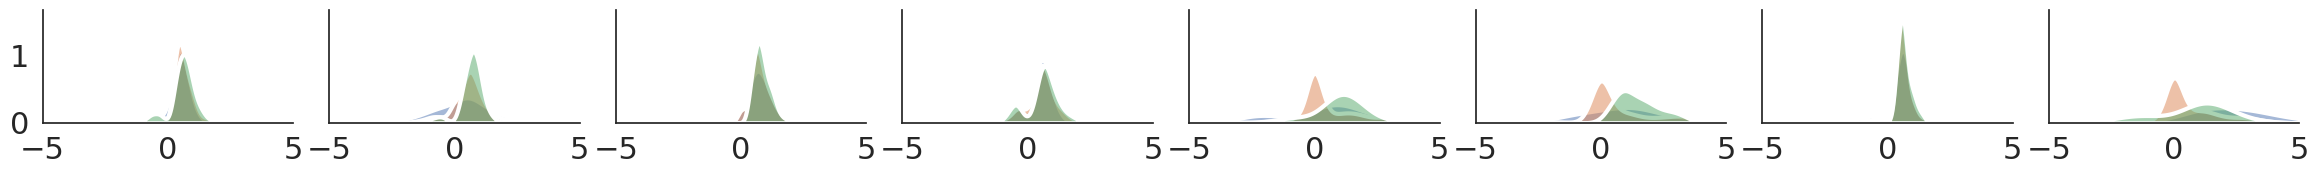

<Figure size 640x480 with 0 Axes>

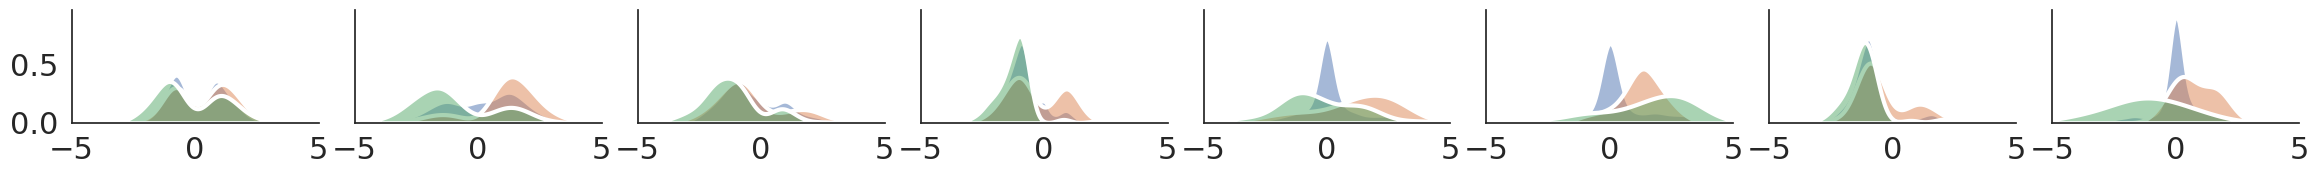

<Figure size 640x480 with 0 Axes>

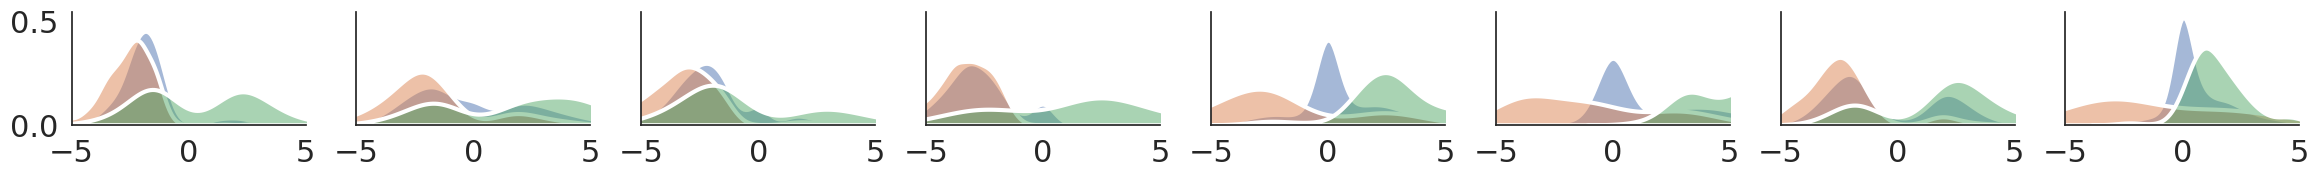

In [445]:
'''to shot the histgram of the disturbance regimes'''
# measurements = {'dist_frequency', 'dist_size','dist_size_median', 'dist_size_prct75', 'dist_size_prct99', 'dist_size_max', 'dist_severity', 'dist_grid_area_adjust'};
regime_indicators = {'frequency', 'size', 'size_max', 'severity'}
regime_indicators = {'frequency', 'size', 'severity'}
dist_agents       = ['General', 'Logging', 'Construction', 'Agricultural change', 'Stress', 'Wind/geohazard', 'Water dynamic', 'Fire']
# dist_agents       = {'Logging', 'Construction', 'Agricultural change', 'Stress', 'Wind/geohazard', 'Water dynamic', 'Fire'}


# define regime table to store the regime information
record_regime     = pandas.DataFrame(columns=['regime', 'agent', 'celeration ', 'count', 'mean', 'median', 'std', 'min', 'max'])
# iterate through the regime indicators
for regime in regime_indicators:
    df_regime_trend = pandas.DataFrame()
    for agt in dist_agents:
        # print(f'Processing {regime} for {agt}')
        # landscape grid -level frequency
        regime_name = f'dist_{regime}'
        # select the dist regime for the agent
        distdata_grid_regime_agent = distdata_grid[distdata_grid['measurement'] == regime_name]
        distdata_grid_regime_agent = distdata_grid_regime_agent[distdata_grid_regime_agent['agent'] == agt]
        # fill nan with zero for the grid
        distdata_grid_regime_agent = distdata_grid_regime_agent.fillna(0)
        
        # label the significant acceleration and deceleration
        distdata_grid_regime_agent['sig_celeration'] = 255 # filled with 255
        # trend is significant
        # celeration is significant
        # when the trend is significant, but the celeration is not significant, we label it as 0
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1)] = 0
        # when trend is positive, and celeration is positive, we label it as 1, which means accelerated increasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] > 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] > 0)] = 1
        # when trend is positive, and celeration is negetive, we label it as -1, which means decelerated increasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] > 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] < 0)] = -1
        # when trend is negetive, and celeration is positive, we label it as 1, which means accelerated decreasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] < 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] < 0)] = 1
        # when trend is negetive, and celeration is negetive, we label it as 1, which means decelerated decreasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] < 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] > 0)] = -1

        # select the significant trend
        distdata_sig_trend = distdata_grid_regime_agent[distdata_grid_regime_agent['TrhY8822'] == 1]
        # change name of sig_celeration values from 1 as to 'accelerated', -1 as to 'decelerated', 0 as to 'stable'
        distdata_sig_trend['sig_celeration'][distdata_sig_trend['sig_celeration'] == 1] = 'Accelerated significant trend'
        distdata_sig_trend['sig_celeration'][distdata_sig_trend['sig_celeration'] == -1] = 'Decelerated significant trend'
        distdata_sig_trend['sig_celeration'][distdata_sig_trend['sig_celeration'] == 0] = 'Other significant trend'
        
        # change TrsY8822 of the field name as to 'Trend'
        distdata_sig_trend = distdata_sig_trend.rename(columns={'TrsY8822': 'trend'})
        
        # define agent name
        distdata_sig_trend['agent'] = agt
        
        # add the data to the dataframe by concatenating
        df_regime_trend = pandas.concat([df_regime_trend, distdata_sig_trend])
    
    # create the new figur with seaborn
    plt.figure()

    g = sns.FacetGrid(df_regime_trend, col="agent", hue = "sig_celeration")
    # limit the x-axis to -5 and 5
    g.map(sns.kdeplot, "trend", multiple = 'stack', lw=3, alpha=0.5, fill=True)
    # larger font
    g.set(xlim=(-5, 5))
    # no x-axis label
    g.set_axis_labels("", "")
    # no titles
    g.set_titles("")


/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



dist_severity - General - Other significant trend: 1431
dist_severity - General - Decelerated significant trend: 556
dist_severity - General - Accelerated significant trend: 126


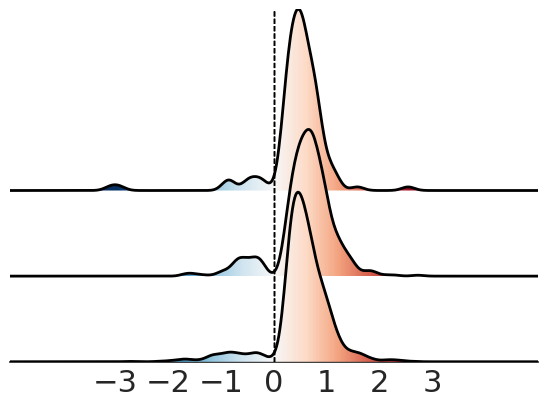

/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



dist_severity - Logging - Other significant trend: 1011
dist_severity - Logging - Decelerated significant trend: 334
dist_severity - Logging - Accelerated significant trend: 50


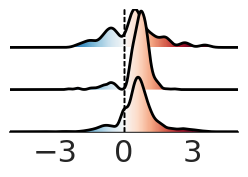

/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



dist_severity - Construction - Other significant trend: 1563
dist_severity - Construction - Decelerated significant trend: 498
dist_severity - Construction - Accelerated significant trend: 99


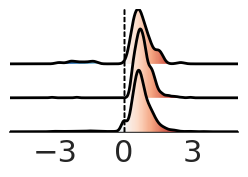

/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



dist_severity - Agricultural change - Other significant trend: 1095
dist_severity - Agricultural change - Decelerated significant trend: 367
dist_severity - Agricultural change - Accelerated significant trend: 120


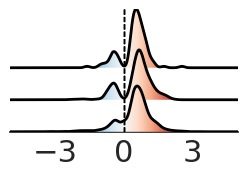

dist_severity - Stress - Other significant trend: 655
dist_severity - Stress - Decelerated significant trend: 48
dist_severity - Stress - Accelerated significant trend: 30


/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



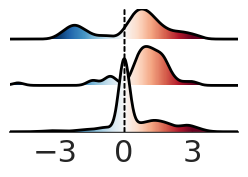

dist_severity - Wind/geohazard - Other significant trend: 482
dist_severity - Wind/geohazard - Decelerated significant trend: 79
dist_severity - Wind/geohazard - Accelerated significant trend: 7


/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



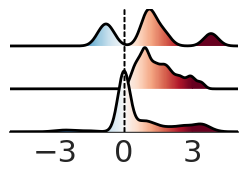

/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



dist_severity - Water dynamic - Other significant trend: 1141
dist_severity - Water dynamic - Decelerated significant trend: 264
dist_severity - Water dynamic - Accelerated significant trend: 92


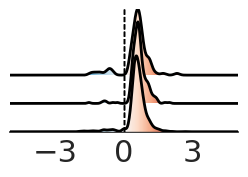

/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



dist_severity - Fire - Other significant trend: 301
dist_severity - Fire - Decelerated significant trend: 20
dist_severity - Fire - Accelerated significant trend: 13


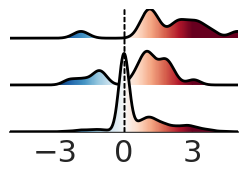

/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



dist_size - General - Other significant trend: 704
dist_size - General - Decelerated significant trend: 188
dist_size - General - Accelerated significant trend: 104


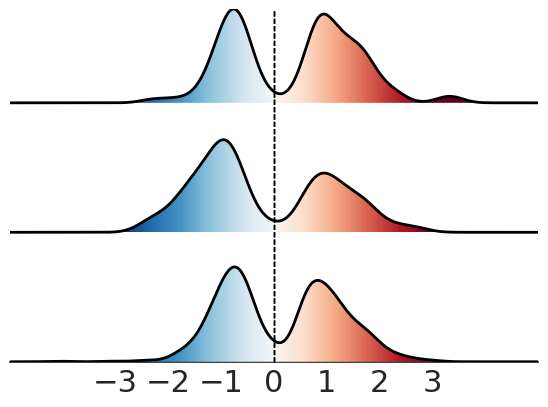

dist_size - Logging - Other significant trend: 791
dist_size - Logging - Decelerated significant trend: 155
dist_size - Logging - Accelerated significant trend: 145


/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



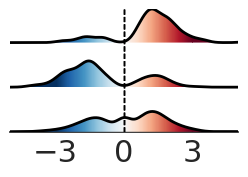

/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



dist_size - Construction - Other significant trend: 760
dist_size - Construction - Decelerated significant trend: 129
dist_size - Construction - Accelerated significant trend: 79


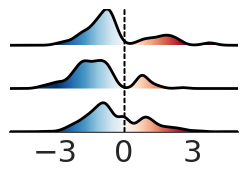

/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



dist_size - Agricultural change - Other significant trend: 689
dist_size - Agricultural change - Decelerated significant trend: 203
dist_size - Agricultural change - Accelerated significant trend: 68


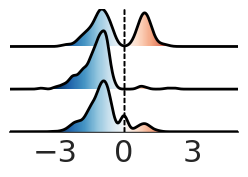

dist_size - Stress - Other significant trend: 610
dist_size - Stress - Decelerated significant trend: 65
dist_size - Stress - Accelerated significant trend: 26


/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



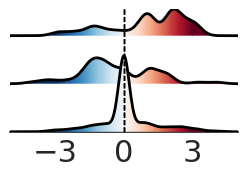

dist_size - Wind/geohazard - Other significant trend: 500
dist_size - Wind/geohazard - Decelerated significant trend: 64
dist_size - Wind/geohazard - Accelerated significant trend: 20


/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



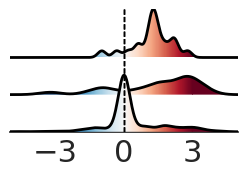

dist_size - Water dynamic - Other significant trend: 457
dist_size - Water dynamic - Decelerated significant trend: 118
dist_size - Water dynamic - Accelerated significant trend: 42


/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



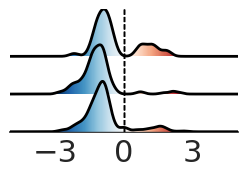

dist_size - Fire - Other significant trend: 295
dist_size - Fire - Decelerated significant trend: 32
dist_size - Fire - Accelerated significant trend: 17


/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



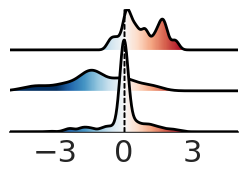

/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



dist_frequency - General - Other significant trend: 932
dist_frequency - General - Decelerated significant trend: 1011
dist_frequency - General - Accelerated significant trend: 95


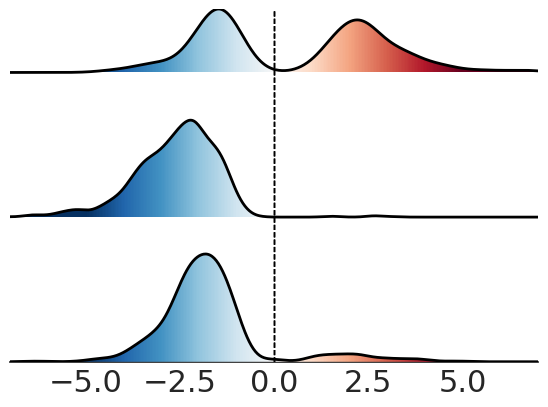

/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



dist_frequency - Logging - Other significant trend: 925
dist_frequency - Logging - Decelerated significant trend: 143
dist_frequency - Logging - Accelerated significant trend: 237


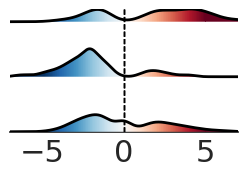

dist_frequency - Construction - Other significant trend: 1251
dist_frequency - Construction - Decelerated significant trend: 515
dist_frequency - Construction - Accelerated significant trend: 75


/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



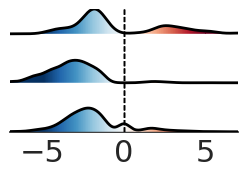

/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



dist_frequency - Agricultural change - Other significant trend: 666
dist_frequency - Agricultural change - Decelerated significant trend: 1760
dist_frequency - Agricultural change - Accelerated significant trend: 30


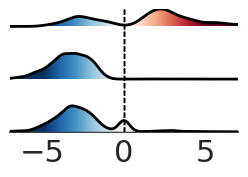

dist_frequency - Stress - Other significant trend: 750
dist_frequency - Stress - Decelerated significant trend: 79
dist_frequency - Stress - Accelerated significant trend: 102


/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



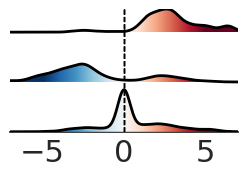

dist_frequency - Wind/geohazard - Other significant trend: 569
dist_frequency - Wind/geohazard - Decelerated significant trend: 49
dist_frequency - Wind/geohazard - Accelerated significant trend: 90


/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



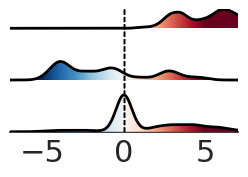

dist_frequency - Water dynamic - Other significant trend: 642
dist_frequency - Water dynamic - Decelerated significant trend: 311
dist_frequency - Water dynamic - Accelerated significant trend: 84


/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



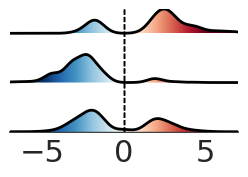

dist_frequency - Fire - Other significant trend: 387
dist_frequency - Fire - Decelerated significant trend: 11
dist_frequency - Fire - Accelerated significant trend: 80


/tmp/ipykernel_2155865/2638498612.py:53: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Accelerated significant trend' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



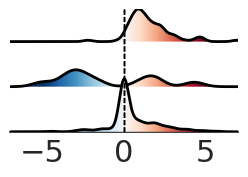

In [459]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Define the order for the hue (sig_celeration)
hue_order = ["Other significant trend",  "Decelerated significant trend", "Accelerated significant trend",]
hue_color = ["#d6604d", "#0571b0", "#999999"]

# iterate through the regime indicators
for regime in regime_indicators:
    df_regime_trend = pandas.DataFrame()
    # Create xs by float numbers with limits from -5 to 5
    if regime == 'frequency':
        full_range = 7.0
        narrow_range = 5
    else:
        full_range = 5.0
        narrow_range = 3
    xs = np.linspace(-narrow_range, narrow_range, 500)
    xs_full = np.linspace(-full_range, full_range, 500)

    for agt in dist_agents:
         # print(f'Processing {regime} for {agt}')
        # landscape grid -level frequency
        regime_name = f'dist_{regime}'
        # select the dist regime for the agent
        distdata_grid_regime_agent = distdata_grid[distdata_grid['measurement'] == regime_name]
        distdata_grid_regime_agent = distdata_grid_regime_agent[distdata_grid_regime_agent['agent'] == agt]
        # fill nan with zero for the grid
        distdata_grid_regime_agent = distdata_grid_regime_agent.fillna(0)
        
        # label the significant acceleration and deceleration
        distdata_grid_regime_agent['sig_celeration'] = 255 # filled with 255
        # trend is significant
        # celeration is significant
        # when the trend is significant, but the celeration is not significant, we label it as 0
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1)] = 0
        # when trend is positive, and celeration is positive, we label it as 1, which means accelerated increasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] > 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] > 0)] = 1
        # when trend is positive, and celeration is negetive, we label it as -1, which means decelerated increasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] > 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] < 0)] = -1
        # when trend is negetive, and celeration is positive, we label it as 1, which means accelerated decreasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] < 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] < 0)] = 1
        # when trend is negetive, and celeration is negetive, we label it as 1, which means decelerated decreasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] < 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] > 0)] = -1

        # select the significant trend
        distdata_sig_trend = distdata_grid_regime_agent[distdata_grid_regime_agent['TrhY8822'] == 1]
        # change name of sig_celeration values from 1 as to 'accelerated', -1 as to 'decelerated', 0 as to 'stable'
        distdata_sig_trend['sig_celeration'][distdata_sig_trend['sig_celeration'] == 1] = 'Accelerated significant trend'
        distdata_sig_trend['sig_celeration'][distdata_sig_trend['sig_celeration'] == -1]= 'Decelerated significant trend'
        distdata_sig_trend['sig_celeration'][distdata_sig_trend['sig_celeration'] == 0] = 'Other significant trend'
        
        # change TrsY8822 of the field name as to 'Trend'
        distdata_sig_trend = distdata_sig_trend.rename(columns={'TrsY8822': 'trend'})
        
        # define agent name
        distdata_sig_trend['agent'] = agt
        
        # add the data to the dataframe by concatenating
        df_regime_trend = pandas.concat([df_regime_trend, distdata_sig_trend])
        
        
        
        if agt == 'General':
            fig, ax = plt.subplots(figsize=(3*2, 2.3*2))
        else:
            fig, ax = plt.subplots(figsize=(3, 2.3))

    
        for index, sig_celeration in enumerate(hue_order):
            subset = df_regime_trend[(df_regime_trend['agent'] == agt) & (df_regime_trend['sig_celeration'] == sig_celeration)]

            # Count the number of grids
            num_grids = len(subset)
            print(f'{regime_name} - {agt} - {sig_celeration}: {num_grids}')
            
            # add reference line x = 0
            # Create a Gaussian KDE for the agent
            kde = gaussian_kde(subset['trend'], bw_method=0.2)
            # Get the density of the trend
            kde_values = kde(xs_full) * 1.6
            
            # Plot the KDE line
            ax.plot(xs_full, index + kde_values, lw=2, color='black', zorder=50 - 2 * index + 1)
            
            # Fill the area under the curve
            fill_poly = ax.fill_between(xs_full, index, index + kde_values, color='none', alpha=0.8)

            
            # Optional: Add gradient color as before
            verts = np.vstack([p.vertices for p in fill_poly.get_paths()])
            # to get the color map 
            cmap = plt.get_cmap('RdBu_r')
            
            gradient = ax.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap=cmap, aspect='auto',
                                zorder=50 - 2 * index, extent=[-narrow_range, narrow_range,
                                                                index, index + kde_values.max()])
            
            # add image out of the narrow range
            gradient_left = ax.imshow(np.linspace(0, 1, 256).reshape(1, -1) <0, cmap = cmap, aspect='auto',
                    zorder=50 - 2 * index, extent=[-full_range, -narrow_range,
                                                    index, index + kde_values.max()])
            gradient_right = ax.imshow(np.linspace(0, 1, 256).reshape(1, -1) <0, cmap = plt.get_cmap('RdBu'), aspect='auto',
                    zorder=50 - 2 * index, extent=[narrow_range, full_range,
                                                    index, index + kde_values.max()])
            gradient.set_clip_path(fill_poly.get_paths()[0], transform=plt.gca().transData)
            gradient_left.set_clip_path(fill_poly.get_paths()[0], transform=plt.gca().transData)
            gradient_right.set_clip_path(fill_poly.get_paths()[0], transform=plt.gca().transData)
            
            ax.axvline(x=0, color='black', lw=1, ls='--', zorder=100)
            #ax.axvline(x=-narrow_range, color='black', lw=1, ls='-', zorder=100)
            # ax.axvline(x=narrow_range, color='black', lw=1, ls='-', zorder=100)
            
        ax.set_xlim(-full_range, full_range)  # Set x-axis limits
        ax.set_ylim(ymin=-0.00)
        ax.set_yticks([])
        ax.set_xlabel('')
        
        for spine in ('top', 'left', 'right'):
            ax.spines[spine].set(visible=False)
        # add outside stickers
        ax.tick_params(axis='x',which='major',  direction='out', length=1)
        if agt == 'General':
            # add stick labels
            ax.set_xticks(np.arange(-narrow_range, narrow_range + 1, 1))
            if regime == 'frequency':
                ax.set_xticks(np.arange(-narrow_range, narrow_range + 1, 2.5))
        else:
            ax.set_xticks([-narrow_range, 0, narrow_range])
        
        plt.tight_layout()
        plt.margins(0, 0)
        plt.subplots_adjust(wspace=0, hspace=0)

        plt.show()


/home/shq19004/miniconda3/envs/dist/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

/home/shq19004/miniconda3/envs/dist/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

/home/shq19004/miniconda3/envs/dist/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

/home/shq19004/miniconda3/envs/dist/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

/home/shq19004/miniconda3/envs/dist/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning:

Tight layout not applied

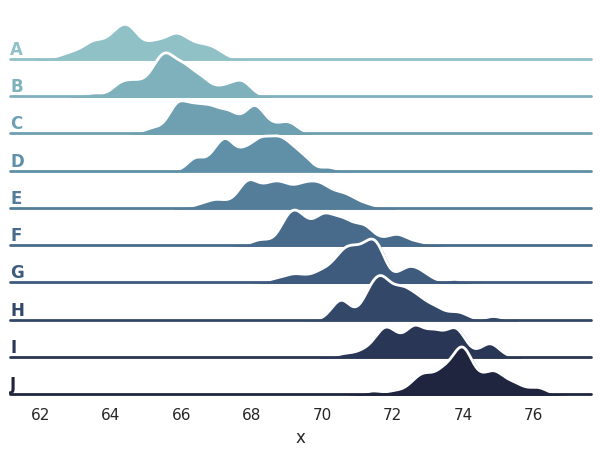

In [176]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [30]:
'''to shot the histgram of the disturbance regimes'''
# measurements = {'dist_frequency', 'dist_size','dist_size_median', 'dist_size_prct75', 'dist_size_prct99', 'dist_size_max', 'dist_severity', 'dist_grid_area_adjust'};
regime_indicators = ['frequency', 'size', 'size_max', 'severity']
dist_agents       = ['General', 'Logging', 'Construction', 'Agricultural change', 'Stress', 'Wind/geohazard', 'Water dynamic', 'Fire']

# define regime table to store the regime information
record_regime     = pandas.DataFrame()
id = 0
# iterate through the regime indicators
for regime in regime_indicators:
    for agt in dist_agents:
        # print(f'Processing {regime} for {agt}')
        # landscape grid -level frequency
        regime_name = f'dist_{regime}'
        # select the dist regime for the agent
        distdata_grid_regime_agent = distdata_grid[distdata_grid['measurement'] == regime_name]
        distdata_grid_regime_agent = distdata_grid_regime_agent[distdata_grid_regime_agent['agent'] == agt]
        # fill nan with zero for the grid
        distdata_grid_regime_agent = distdata_grid_regime_agent.fillna(0)
        
        # label the significant acceleration and deceleration
        distdata_grid_regime_agent['sig_celeration'] = 255 # filled with 255
        # trend is significant
        # celeration is significant
        # when the trend is significant, but the celeration is not significant, we label it as 0
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1)] = 0
        # when trend is positive, and celeration is positive, we label it as 1, which means accelerated increasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] > 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] > 0)] = 1
        # when trend is positive, and celeration is negetive, we label it as -1, which means decelerated increasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] > 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] < 0)] = -1
        # when trend is negetive, and celeration is positive, we label it as 1, which means accelerated decreasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] < 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] < 0)] = 1
        # when trend is negetive, and celeration is negetive, we label it as 1, which means decelerated decreasing.
        distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] < 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] > 0)] = -1

        # to get the value list of the regime
        _list_acceleration = distdata_grid_regime_agent[distdata_grid_regime_agent['sig_celeration'] == 1]['TrsY8822'] # significant acceleration
        _list_deceleration = distdata_grid_regime_agent[distdata_grid_regime_agent['sig_celeration'] == -1]['TrsY8822'] # significant acceleration
        _list_stable = distdata_grid_regime_agent[distdata_grid_regime_agent['sig_celeration'] == 0]['TrsY8822'] # significant acceleration


        # to get value list of the regime
        _list_trend = distdata_grid_regime_agent['TrsY8822'] # trend
        # to get the significant trend
        _list_trend_sig = distdata_grid_regime_agent[distdata_grid_regime_agent['TrhY8822'] == 1]['TrsY8822'] # significant trend
        
        # to get the significant celeration for positive trends, only based on the significant trends
        distdata_grid_positive_sig_trend = distdata_grid_regime_agent[(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] > 0)]
        _list_accelerated_positive_sig_trend = distdata_grid_positive_sig_trend[(distdata_grid_positive_sig_trend['CTrhY8822'] == 1) & (distdata_grid_positive_sig_trend['CTrsY8822'] > 0)]['CTrsY8822']
        _list_decelerated_positive_sig_trend = distdata_grid_positive_sig_trend[(distdata_grid_positive_sig_trend['CTrhY8822'] == 1) & (distdata_grid_positive_sig_trend['CTrsY8822'] < 0)]['CTrsY8822']
        _list_other_positive_sig_trend       = distdata_grid_positive_sig_trend[(distdata_grid_positive_sig_trend['CTrhY8822'] == 0) | (distdata_grid_positive_sig_trend['CTrsY8822'] == 0)]['CTrsY8822'] # non-significant celeration or zero celeration
        
        # to get the significant celeration for negative trends, only based on the significant trends
        distdata_grid_negative_sig_trend = distdata_grid_regime_agent[(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] < 0)]
        _list_accelerated_negative_sig_trend = distdata_grid_negative_sig_trend[(distdata_grid_negative_sig_trend['CTrhY8822'] == 1) & (distdata_grid_negative_sig_trend['CTrsY8822'] < 0)]['CTrsY8822']
        _list_decelerated_negative_sig_trend = distdata_grid_negative_sig_trend[(distdata_grid_negative_sig_trend['CTrhY8822'] == 1) & (distdata_grid_negative_sig_trend['CTrsY8822'] > 0)]['CTrsY8822']
        _list_other_negative_sig_trend       = distdata_grid_negative_sig_trend[(distdata_grid_negative_sig_trend['CTrhY8822'] == 0) | (distdata_grid_negative_sig_trend['CTrsY8822'] == 0)]['CTrsY8822'] # non-significant celeration or zero celeration
        
        record_regime = pandas.concat([record_regime, 
                                pandas.DataFrame({'id':id,
                                    'regime': regime,
                                                'agent': agt,
                                                'mean_trend': np.mean(_list_trend),
                                                'prop_pos_trend': len(_list_trend[_list_trend > 0]) / len(_list_trend),
                                                'prop_neg_trend': len(_list_trend[_list_trend < 0]) / len(_list_trend),
                                                'prop_pos_sig_trend': len(_list_trend_sig[_list_trend_sig > 0]) / len(_list_trend),
                                                'prop_neg_sig_trend': len(_list_trend_sig[_list_trend_sig < 0]) / len(_list_trend),
                                                'prop_pos_sig_trend_accelerated': len(_list_accelerated_positive_sig_trend) / len(distdata_grid_positive_sig_trend),
                                                'prop_pos_sig_trend_decelerated': len(_list_decelerated_positive_sig_trend) / len(distdata_grid_positive_sig_trend),
                                                'prop_pos_sig_trend_other': len(_list_other_positive_sig_trend) / len(distdata_grid_positive_sig_trend),
                                                'prop_neg_sig_trend_accelerated': len(_list_accelerated_negative_sig_trend) / len(distdata_grid_negative_sig_trend),
                                                'prop_neg_sig_trend_decelerated': len(_list_decelerated_negative_sig_trend) / len(distdata_grid_negative_sig_trend),
                                                'prop_neg_sig_trend_other': len(_list_other_negative_sig_trend) / len(distdata_grid_negative_sig_trend),
                                                'count_trend': len(_list_trend),
                                                'count_pos_trend': len(_list_trend[_list_trend > 0]),
                                                'count_neg_trend': len(_list_trend[_list_trend < 0]),
                                                'count_pos_sig_trend': len(_list_trend_sig[_list_trend_sig > 0]),
                                                'count_neg_sig_trend': len(_list_trend_sig[_list_trend_sig < 0]),
                                                'count_pos_sig_trend_accelerated': len(_list_accelerated_positive_sig_trend),
                                                'count_pos_sig_trend_decelerated': len(_list_decelerated_positive_sig_trend),
                                                'count_pos_sig_trend_other': len(_list_other_positive_sig_trend),
                                                'count_neg_sig_trend_accelerated': len(_list_accelerated_negative_sig_trend),
                                                'count_neg_sig_trend_decelerated': len(_list_decelerated_negative_sig_trend),
                                                'count_neg_sig_trend_other': len(_list_other_negative_sig_trend),
                                            }, index=[0])], ignore_index=True)
        id = id + 1 
 
# save at the end
# sorted record_regime by the regime list, that is frequency, size, and severity
# sort the regime by sotred by agent, that is general, logging, construction, agricultural change, stress, wind/geohazard, water dynamic, and fire
record_regime = record_regime.sort_values(by=['id'])
# limit the decimal to 6
record_regime = record_regime.round(6)

# print the record_regime
print(record_regime)
# save regime information to csv
record_regime.to_csv('regime_shift_celeration_conus_table.csv', index=False)
 

/tmp/ipykernel_1491803/2148667908.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1)] = 0
/tmp/ipykernel_1491803/2148667908.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] > 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] > 0)] = 1
/tmp/ipykernel_1491803/2148667908.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

    id     regime                agent  mean_trend  prop_pos_trend  \
0    0  frequency              General   -1.361399        0.148629   
1    1  frequency              Logging    0.045496        0.298142   
2    2  frequency         Construction   -1.324600        0.121498   
3    3  frequency  Agricultural change   -2.383572        0.042465   
4    4  frequency               Stress    0.184992        0.185491   
5    5  frequency       Wind/geohazard    0.353636        0.109997   
6    6  frequency        Water dynamic   -0.335595        0.337364   
7    7  frequency                 Fire    0.111936        0.119434   
8    8       size              General   -0.028175        0.430551   
9    9       size              Logging    0.058633        0.358006   
10  10       size         Construction   -0.202091        0.294014   
11  11       size  Agricultural change   -0.363081        0.239162   
12  12       size               Stress    0.025230        0.153937   
13  13       size   

/tmp/ipykernel_1491803/2148667908.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1)] = 0
/tmp/ipykernel_1491803/2148667908.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distdata_grid_regime_agent['sig_celeration'][(distdata_grid_regime_agent['TrhY8822'] == 1) & (distdata_grid_regime_agent['TrsY8822'] > 0) & (distdata_grid_regime_agent['CTrhY8822'] == 1) & (distdata_grid_regime_agent['CTrsY8822'] > 0)] = 1
/tmp/ipykernel_1491803/2148667908.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [4]:
'''to get the regime inforamtion'''
# measurements = {'dist_frequency', 'dist_size','dist_size_median', 'dist_size_prct75', 'dist_size_prct99', 'dist_size_max', 'dist_severity', 'dist_grid_area_adjust'};

regime_indicators = {'frequency', 'size', 'size_max', 'severity'}
dist_agents       = {'General', 'Logging', 'Construction', 'Agricultural change', 'Stress', 'Wind/geohazard', 'Water dynamic', 'Fire'}
# define regime table to store the regime information
record_regime     = pandas.DataFrame(columns=['regime', 'agent', 'mean', 'min', 'q01', 'q25', 'q50', 'q75', 'q99', 'max', 'std'])
# iterate through the regime indicators
for regime in regime_indicators:
    for agt in dist_agents:
        # print(f'Processing {regime} for {agt}')
        # landscape grid -level frequency
        regime_name = f'dist_{regime}'
        # select the dist regime for the agent
        distdata_grid_regime_agent = distdata_grid[distdata_grid['measurement'] == regime_name]
        distdata_grid_regime_agent = distdata_grid_regime_agent[distdata_grid_regime_agent['agent'] == agt]
        # fill nan with zero for the grid
        distdata_grid_regime_agent = distdata_grid_regime_agent.fillna(0)
        # to get value list of the regime
        _value = distdata_grid_regime_agent['TrsY8822'] # trend
        _value_sig = distdata_grid_regime_agent['TrhY8822'] # significance of the trend
 
        # to get the regime information for the agent
        _mean = _value.mean()
        _min = _value.min()
        _q01 = _value.quantile(0.01)
        _q25 = _value.quantile(0.25)
        _q50 = _value.quantile(0.50)
        _q75 = _value.quantile(0.75)
        _q99 = _value.quantile(0.99)
        _max = _value.max()
        _std = _value.std()
        _pos_prop = len(_value[_value > 0])/len(_value)
        _neg_prop = len(_value[_value < 0])/len(_value)
    
        # add the regime information to the record_regime by concatenating the dataframe
        record_regime = pandas.concat([record_regime, 
                                       pandas.DataFrame({'regime': regime, 'agent': agt, 'mean': _mean, 'min': _min, 'q01': _q01, 'q25': _q25, 'q50': _q50, 'q75': _q75, 'q99': _q99, 'max': _max, 'std': _std, 'pos_prop':_pos_prop, 'neg_prop': _neg_prop}, index=[0])], ignore_index=True)

# sorted record_regime by the regime list, that is frequency, size, and severity
record_regime = record_regime.sort_values(by=['regime', 'agent'])

# print the record_regime
print(record_regime)

# save regime information to csv
record_regime.to_csv('regime_shift_conus.csv', index=False)

/tmp/ipykernel_1273513/2631601183.py:37: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



       regime                agent      mean        min       q01       q25  \
2   frequency  Agricultural change -2.383572  -7.630259 -6.326760 -3.659711   
1   frequency         Construction -1.324600  -8.613264 -5.720829 -2.539248   
5   frequency                 Fire  0.111936  -5.026930 -1.318003  0.000000   
0   frequency              General -1.361399  -7.197679 -5.078394 -2.312240   
7   frequency              Logging  0.045496  -6.487488 -3.980294 -0.785349   
6   frequency               Stress  0.184992  -7.451338 -3.545391  0.000000   
4   frequency        Water dynamic -0.335595  -6.916996 -4.371729 -1.331305   
3   frequency       Wind/geohazard  0.353636  -5.050505 -3.251645 -0.000000   
10   severity  Agricultural change  0.263777  -3.257143 -1.292025 -0.000000   
9    severity         Construction  0.514987  -3.296703 -1.458341 -0.000000   
13   severity                 Fire  0.076564  -2.548209 -0.884128  0.000000   
8    severity              General  0.359181  -3.091